# Drug Simulation (dummy example)

This vignette displays some examples of what can be achieved using **NORDic** in order to simulate and score the drug effect. The higher the score, the more promising the drug is to treat the disease.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.6.0


## Simulation of drug effect based on a Boolean network

**NORDic DS** uses a Boolean network and a set of patient and healthy phenotypes to score the suitability of a drug for repurposing.

The input network does not need to be an output of **NORDic NI**, and the corresponding .BNET file can be independenty generated. We illustrate this by feeding to **NORDic DR** a dummy example.

In [2]:
from subprocess import call as sbcall
save_folder="MODELS/dummy/"
sbcall("mkdir -p "+save_folder, shell=True)

0

### A. Creating the dummy network example (the same as the one in **NORDic PMR**)

The dummy example has 11 genes named X0, X1, ..., X10 (with one isolated gene X10), and 20 edges.

In [3]:
import pandas as pd
import numpy as np
np.random.seed(12345)

## List of input nodes for each edge
source = list(map(lambda x: "X%d" % x,[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5,8,9]))
## List of target nodes for each edge
target = list(map(lambda x : "X%d" % x,[2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9,0,8]))

## List of all genes
genes = list(sorted(list(set(source+target))))+["X10"]

## Create the network (adjacency matrix)
influences = np.zeros((len(genes), len(genes)))
for s, t in zip(source, target):
    influences[genes.index(s)][genes.index(t)] = np.random.choice([-1,1], p=None, size=1)
influences = pd.DataFrame(influences, index=genes, columns=genes).astype(int)
influences

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
X0,0,0,-1,1,1,1,-1,1,-1,-1,0
X1,0,0,1,-1,1,1,-1,1,1,-1,0
X2,0,0,0,0,0,0,1,0,0,0,0
X3,0,0,0,0,0,0,0,1,0,0,0
X4,0,0,0,0,0,0,0,0,1,0,0
X5,0,0,0,0,0,0,0,0,0,-1,0
X6,0,0,0,0,0,0,0,0,0,0,0
X7,0,0,0,0,0,0,0,0,0,0,0
X8,-1,0,0,0,0,0,0,0,0,0,0
X9,0,0,0,0,0,0,0,0,-1,0,0


Let us plot the network using **NORDic** functions, and save the corresponding image in *save_folder*/example.png. Parameter *optional* traces edges with dashed lines when set to True, resp. with solid lines when set to False.

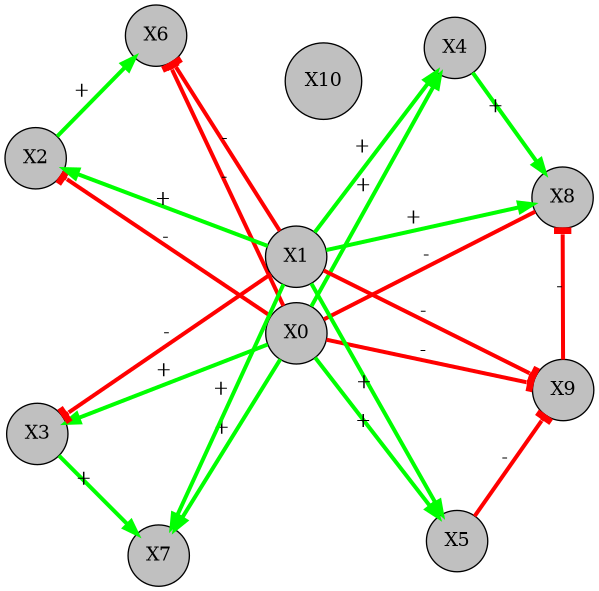

In [4]:
from NORDic.UTILS.utils_plot import influences2graph

influences2graph(influences, save_folder+"example", optional=False, 
                 compile2png=True, engine="sfdp")
from IPython.display import Image
Image(filename=save_folder+'example.png') 

Now that we have built the topology of the network, its dynamics remain to be defined. In that case, we assume that at least one activator (i.e., regulator connected with an activatory edge) should be active (i.e., an "active" expression level) and no inhibitor being active for the regulated gene to be active.

In [5]:
## Gene regulatory functions (for each node in the network)

grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf, sign = grfs.get(t, {}), influences.loc[s][t]
    if (sign==0):
        continue
    grf.update({s: sign})
    grfs.update({t: grf})
grfs

{'X2': {'X0': -1, 'X1': 1},
 'X3': {'X0': 1, 'X1': -1},
 'X4': {'X0': 1, 'X1': 1},
 'X5': {'X0': 1, 'X1': 1},
 'X6': {'X0': -1, 'X1': -1, 'X2': 1},
 'X7': {'X0': 1, 'X1': 1, 'X3': 1},
 'X8': {'X0': -1, 'X1': 1, 'X4': 1, 'X9': -1},
 'X9': {'X0': -1, 'X1': -1, 'X5': -1},
 'X0': {'X8': -1}}

Now, let us write down the corresponding .BNET file *save_folder*/example.bnet

In [6]:
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            activators = [r for r in grfs[g] if (grfs[g][r]>0)]
            inhibitors = ["!"+r for r in grfs[g] if (grfs[g][r]<0)]
            network += [g+", "+("("+"|".join(activators)+")" if (len(activators)>0) else "")
                        +("&" if ((len(activators)>0) and (len(inhibitors)>0)) else "")
                        +("("+"&".join(inhibitors)+")" if (len(inhibitors)>0) else "")] 
        else:
            network += [g+", 1"]
    f.write("\n".join(network))
    
## Print the resulting network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([", ".join(s.split(", ")) for s in network.split("\n")]))

X0, (!X8)
X1, 1
X2, (X1)&(!X0)
X3, (X0)&(!X1)
X4, (X0|X1)
X5, (X0|X1)
X6, (X2)&(!X0&!X1)
X7, (X0|X1|X3)
X8, (X1|X4)&(!X0&!X9)
X9, (!X0&!X1&!X5)
X10, 1


### B. Creating a set of patient and healthy samples

Let us consider a disease which is caused by a knockout of genes X1 and X8, whereas X1 and X8 are supposed to be active in control ("healthy") samples. Let us use the network and mpbn-sim [[1]](https://github.com/bnediction/mpbn-sim) to generate patient and control samples.

> Roncalli, Théo, and Loïc Paulevé. "Variable-Depth Simulation of Most Permissive Boolean Networks." International Conference on Computational Methods in Systems Biology. Springer, Cham, 2022.

In [7]:
import mpbn
from tqdm import tqdm
from multiprocessing import cpu_count
import os

njobs=max(1,cpu_count()-2)
SIMU_params = {
    'nb_sims': 1000,
    'rates': "uniform",
    #weighting vector W=(W1, W2, ..., Wn) weight of a transition changing n components at a time
    #rates="uniform": W=(1,1,...,1)
    #rates="fully_asynchronous": 1 component at a time is changed, meaning W=(1, 0, ..., 0)
    #rates="reciprocal": undocumented
    #rates="nexponential": (sampling weight from an exponentially decreasing distr.)
    'thread_count': njobs,
    'depth': "nexponential", 
    #depth="constant_unitary" (depth=1): asynchronous transitions
    #depth=2: target expression can change while regulator expression changes
    #depth=3: target of target expression can change while target expression changes, etc.
    #depth="constant_maximum" (depth=N, where N is the number of nodes in the network)
    #depth="nexponential" (sampling depth from an exponentially decreasing distr.)
}
network_name = save_folder+"example.bnet"
assert SIMU_params["depth"] in ["constant_maximum", "constant_unitary", "nexponential"]
assert SIMU_params["rates"] in ["fully_asynchronous", "uniform", "reciprocal", "nexponential"]

## Create the mutated networks
def patch_model(f, patch):
    f = mpbn.MPBooleanNetwork(f)
    for i, fi in patch.items():
        f[i] = fi
    return f
experiments = [{"name": "mpsim", "rates": SIMU_params["rates"], "depth": SIMU_params["depth"]}]
nb_sims = SIMU_params["nb_sims"]

if (not os.path.exists(save_folder+"phenotypes.csv")):
    f_wildtype = mpbn.load(network_name)
    ## Initial states drawn at random
    state_len = 10
    states = pd.DataFrame(
      [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
      , columns=genes, index=range(state_len)).T
    A_WT, A_mut = [], []
    for state in tqdm(states.columns):
        x0 = f_wildtype.zero()
        for i in list(states.loc[states[state]==1].columns):
            x0[i] = 1
        x0["X1"] = 1 # in wild type
        x0["X8"] = 1 # in wild type
        f_mutant = patch_model(f_wildtype, {"X1": 0, "X8": 0})
        ## Get the reachable attractors from initial state in the presence/absence of X0 knockout
        A_WT += [a for a in tqdm(list(f_wildtype.attractors(reachable_from=x0)))]
        A_mut += [a for a in tqdm(list(f_mutant.attractors(reachable_from=x0)))]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37117.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41943.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40721.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39945.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39945.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40329.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36792.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████

In [8]:
for a in A_WT:
    a.update({"annotation": 1})
for a in A_mut:
    a.update({"annotation": 2})
controls = {"Control%d" % (i+1): a for i,a in enumerate(A_WT)}
patients = {"Case%d" % (i+1): a for i,a in enumerate(A_mut)}
controls.update(patients)
states = pd.DataFrame(controls)
states

,Control1,Control2,Control3,Control4,Control5,Control6,Control7,Control8,Control9,Control10,Case1,Case2,Case3,Case4,Case5,Case6,Case7,Case8,Case9,Case10
X0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
X1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
X2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
X3,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
X4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
X5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
X6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
X7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
X8,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
X9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### C. Generate a set of drugs (with their direct gene targets)

In [9]:
targets = pd.DataFrame({
    "Cure": {"X1": 1, "X8": 1}, 
    "Sham1": {"X1": -1, "X10": 1},
    "CureX8": {"X2": -1, "X8": 1},
    "CureX8WrongX1": {"X1": -1, "X8": 1},
    "CureX1": {"X1": 1},
    "Sham2": {"X2": -1, "X3": 1},
})
all_genes = pd.DataFrame({"One": {g: 0 for g in genes}})
targets = targets.join(all_genes, how="outer").fillna(0)[[c for c in targets.columns if (c!="One")]].astype(int)
targets

,Cure,Sham1,CureX8,CureX8WrongX1,CureX1,Sham2
X0,0,0,0,0,0,0
X1,1,-1,0,-1,1,0
X10,0,1,0,0,0,0
X2,0,0,-1,0,0,-1
X3,0,0,0,0,0,1
X4,0,0,0,0,0,0
X5,0,0,0,0,0,0
X6,0,0,0,0,0,0
X7,0,0,0,0,0,0
X8,1,0,1,1,0,0


### D. Drug scoring

In [10]:
## Define the function which determines whether a state is closer to controls/patients
dfdata = states.loc[[i for i in states.index if (i != "annotation")]]
samples = states.loc["annotation"]
from NORDic.NORDic_DS.functions import compute_frontier
## compute_frontier fits a SVM model to the data
frontier = compute_frontier(dfdata, samples)
score = lambda attrs : (frontier.predict(attrs.values.T)==1).astype(int)

## Patient profiles
patients = states[[c for c in states.columns if ("Case" in c)]].loc[[i for i in states.index if (i != "annotation")]]

from NORDic.NORDic_DS.functions import simulate
scores = simulate(network_name, targets, patients, score, simu_params=SIMU_params, nbseed=0)

<NORD_DS> Accuracy of the model 1.00
	<NORD_DS> Initial state Case2
Drug Cure (1/6) in state Case2 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case5
Drug Cure (1/6) in state Case5 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case2 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case5 - nexponential_depth{}	uniform_rates{}
Drug CureX8 (3/6) in state Case2 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case9
	<NORD_DS> Initial state Case7
Drug Cure (1/6) in state Case9 - nexponential_depth{}	uniform_rates{}
Drug Cure (1/6) in state Case7 - nexponential_depth{}	uniform_rates{}
Drug CureX8 (3/6) in state Case5 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case10
Drug Cure (1/6) in state Case10 - nexponential_depth{}	uniform_rates{}
Drug CureX8WrongX1 (4/6) in state Case2 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case9 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in 

100%|██████████| 1/1 [00:00<00:00, 60787.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 47274.15it/s]

Drug Sham2 (6/6) in state Case10 - nexponential_depth{}	uniform_rates{}
Drug CureX1 (5/6) in state Case3 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case1
Drug Cure (1/6) in state Case1 - nexponential_depth{}	uniform_rates{}
Drug Sham2 (6/6) in state Case3 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case1 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case6
Drug Cure (1/6) in state Case6 - nexponential_depth{}	uniform_rates{}
	<NORD_DS> Initial state Case4
Drug Cure (1/6) in state Case4 - nexponential_depth{}	uniform_rates{}
Drug CureX8 (3/6) in state Case1 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case6 - nexponential_depth{}	uniform_rates{}
Drug Sham1 (2/6) in state Case4 - nexponential_depth{}	uniform_rates{}
Drug CureX8WrongX1 (4/6) in state Case1 - nexponential_depth{}	uniform_rates{}
Drug CureX8 (3/6) in state Case6 - nexponential_depth{}	uniform_rates{}
Drug CureX8 (3/6) in state Case4 - nexponentia


100%|██████████| 1000/1000 [00:00<00:00, 45646.82it/s]

100%|██████████| 1000/1000 [00:00<00:00, 58012.50it/s]

Function *simulate* returns a dataframe where rows are patient profiles and columns are drugs. Each coefficient in this dataframe is the sum, across reachable attractors from the patient profile on which perturbations induced by the drug (in *targets*) have been applied, of the indicators of whether this reachable attractor belongs to the set of healthy profiles, weighted by the propensity of that attractor. The membership of a given attractor to the set of healthy profiles is determined by a Support Vector Model (SVM) trained on the set of patient and healthy phenotypes.

In [11]:
scores

,Cure,Sham1,CureX8,CureX8WrongX1,CureX1,Sham2
Case1,1.0,0.0,1.0,1.0,0.0,0.0
Case2,1.0,0.0,1.0,1.0,0.0,0.0
Case3,1.0,0.0,1.0,1.0,0.0,0.0
Case4,1.0,0.0,1.0,1.0,0.0,0.0
Case5,1.0,0.0,1.0,1.0,0.0,0.0
Case6,1.0,0.0,1.0,1.0,0.0,0.0
Case7,1.0,0.0,1.0,1.0,0.0,0.0
Case8,1.0,0.0,1.0,1.0,0.0,0.0
Case9,1.0,0.0,1.0,1.0,0.0,0.0
Case10,1.0,0.0,1.0,1.0,0.0,0.0


### E. Results

A simple way to rank these drugs is to compute the average score of a given drug across patient profiles:

In [12]:
scores.mean(axis=0).sort_values(ascending=False)

Cure             1.0
CureX8           1.0
CureX8WrongX1    1.0
Sham1            0.0
CureX1           0.0
Sham2            0.0
dtype: float64

We have indeed found that the treatment that overexpress X8 ("Cure", "CureX8", "CureX8WrongX1") are susceptible to be promising candidates. Indeed, the one that both overexpresses X8 and X1 ("Cure") is among the top ones, but the one only overexpressing X1 ("CureX1") turns out not so good. This is probably due to the interactions between X0 and X8 (see graph).